## **Example. Stratified sampling in pre-election polling**

In [421]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
import scipy.stats as stats
import theano.tensor as tt
import arviz
import seaborn
import time
from scipy.special import expit as logistic
from scipy.special import logit

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.style.use('seaborn-darkgrid')
plt.rc('font', size=12)

%config Inline.figure_formats = ['retina']

In [4]:
# arviz.style.use('arviz-darkgrid')

A survey of 1447 adults.

In [5]:
participants = 1447

This is the Table 8.2

In [6]:
data = pd.read_csv('data/cbs_survey.txt', sep=' ', skiprows=2, skipinitialspace=True, index_col=False)
data

,region,density,bush,dukakis,other,proportion
0,Northeast,I,0.298,0.617,0.085,0.032
1,Northeast,II,0.500,0.478,0.022,0.032
2,Northeast,III,0.467,0.413,0.120,0.115
3,Northeast,IV,0.464,0.522,0.014,0.048
4,Midwest,I,0.404,0.489,0.106,0.032
5,Midwest,II,0.447,0.447,0.106,0.065
6,Midwest,III,0.509,0.388,0.103,0.080
7,Midwest,IV,0.552,0.338,0.110,0.100
8,South,I,0.571,0.286,0.143,0.015
9,South,II,0.469,0.406,0.125,0.066


In [7]:
#data.density

We need the number of people of each region and each candidate.

In [8]:
data_obs = data[['bush', 'dukakis', 'other']].to_numpy()
print(data_obs)

[[0.298 0.617 0.085]
 [0.5   0.478 0.022]
 [0.467 0.413 0.12 ]
 [0.464 0.522 0.014]
 [0.404 0.489 0.106]
 [0.447 0.447 0.106]
 [0.509 0.388 0.103]
 [0.552 0.338 0.11 ]
 [0.571 0.286 0.143]
 [0.469 0.406 0.125]
 [0.515 0.404 0.081]
 [0.555 0.352 0.093]
 [0.5   0.471 0.029]
 [0.532 0.351 0.117]
 [0.54  0.371 0.089]
 [0.554 0.361 0.084]]


In [9]:
proportion = data['proportion'].to_numpy() * participants
print(proportion)

[ 46.304  46.304 166.405  69.456  46.304  94.055 115.76  144.7    21.705
  95.502  98.396 182.322  33.281  76.691 124.442  82.479]


In [10]:
np.sum(proportion)

1444.106

In [11]:
print(data_obs.shape)
print(proportion.shape)

(16, 3)
(16,)


In [12]:
values = data_obs[:, :] * proportion.reshape(16, -1)
values = np.round(values)
np.sum(values)   # Check if the sum is equal to 1447

1447.0

In [13]:
values

array([[ 14.,  29.,   4.],
       [ 23.,  22.,   1.],
       [ 78.,  69.,  20.],
       [ 32.,  36.,   1.],
       [ 19.,  23.,   5.],
       [ 42.,  42.,  10.],
       [ 59.,  45.,  12.],
       [ 80.,  49.,  16.],
       [ 12.,   6.,   3.],
       [ 45.,  39.,  12.],
       [ 51.,  40.,   8.],
       [101.,  64.,  17.],
       [ 17.,  16.,   1.],
       [ 41.,  27.,   9.],
       [ 67.,  46.,  11.],
       [ 46.,  30.,   7.]])

### **Nonhierarchical model**

In [14]:
with pm.Model() as model_non_hiera:
    
    thetas = pm.Dirichlet('thetas', a=np.ones_like(data_obs), shape=(16, 3))
    post = pm.Multinomial('post', n=np.sum(values, axis=1), p=thetas, observed=values)

In [15]:
model_non_hiera.check_test_point()

thetas_stickbreaking__    -41.64
post                     -322.85
Name: Log-probability of test_point, dtype: float64

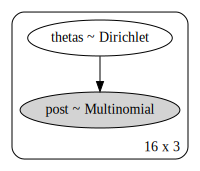

In [16]:
pm.model_to_graphviz(model_non_hiera)

In [17]:
with model_non_hiera:
    trace_1 = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetas]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:12<00:00, 1261.82draws/s]


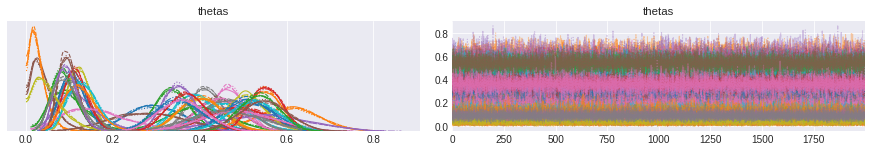

In [18]:
pm.traceplot(trace_1, var_names=['thetas']);

In [19]:
arviz.summary(trace_1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"thetas[0,0]",0.300,0.064,0.187,0.423,0.000,0.000,20339.0,17763.0,20322.0,6069.0,1.0
"thetas[0,1]",0.600,0.069,0.470,0.727,0.000,0.000,19390.0,19180.0,19552.0,6245.0,1.0
"thetas[0,2]",0.100,0.043,0.029,0.180,0.000,0.000,18595.0,12076.0,18709.0,5858.0,1.0
"thetas[1,0]",0.490,0.070,0.362,0.622,0.001,0.000,19511.0,18547.0,19485.0,5735.0,1.0
"thetas[1,1]",0.469,0.070,0.333,0.591,0.001,0.000,19212.0,18708.0,19202.0,5792.0,1.0
"thetas[1,2]",0.041,0.028,0.001,0.090,0.000,0.000,13816.0,8597.0,14282.0,5384.0,1.0
"thetas[2,0]",0.465,0.038,0.395,0.538,0.000,0.000,20807.0,20050.0,20958.0,5981.0,1.0
"thetas[2,1]",0.411,0.037,0.343,0.484,0.000,0.000,19349.0,19002.0,19357.0,6140.0,1.0
"thetas[2,2]",0.124,0.026,0.078,0.172,0.000,0.000,19153.0,15896.0,19292.0,6033.0,1.0
"thetas[3,0]",0.458,0.059,0.349,0.566,0.000,0.000,20735.0,20200.0,20643.0,5127.0,1.0


Now, the goal is to reproduce the figure 8.1 (a).

In [20]:
with model_non_hiera:
    ppc_non_hiera = pm.sample_posterior_predictive(trace_1, samples=10_000, vars=[thetas, post])

100%|██████████| 10000/10000 [00:16<00:00, 624.90it/s]


In [21]:
ppc_non_hiera['thetas'].shape

(10000, 16, 3)

Just check if the column **proportion** (look at the data frame) is equal to what we got.

In [22]:
proportion / np.sum(proportion)

array([0.03206413, 0.03206413, 0.11523046, 0.04809619, 0.03206413,
       0.06513026, 0.08016032, 0.1002004 , 0.01503006, 0.06613226,
       0.06813627, 0.12625251, 0.02304609, 0.05310621, 0.08617234,
       0.05711423])

In [23]:
diff = []

for i in range(16):
    result = ppc_non_hiera['thetas'][:, i, 0] - ppc_non_hiera['thetas'][:, i, 1]
    diff.append(list(result))

In [24]:
diff = np.asarray(diff)
diff

array([[-0.37152868, -0.39270884, -0.27711763, ..., -0.38311389,
        -0.16197354, -0.0759135 ],
       [-0.09074752,  0.1115859 ,  0.00146911, ...,  0.01069888,
         0.02267581,  0.07319762],
       [-0.06447657,  0.13304329,  0.04881421, ..., -0.05086837,
         0.17782086,  0.1470372 ],
       ...,
       [ 0.22232482,  0.04534385,  0.12250542, ...,  0.21818491,
         0.12880619,  0.17687064],
       [ 0.23422029,  0.29562229, -0.01020674, ...,  0.10753941,
         0.21011965,  0.22453465],
       [ 0.12189831,  0.05450111,  0.13657609, ...,  0.22938518,
         0.18281768,  0.21130112]])

In [25]:
result = np.sum(diff.T * proportion / np.sum(proportion), axis=1)

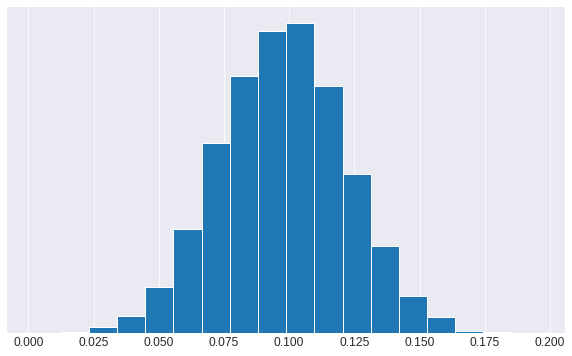

In [26]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(result, bins=18, edgecolor='w', density=True)
plt.yticks([]);

In [27]:
np.mean(result)

0.09751035970690071

The figure is almost the same!

### **Hierarchichal model**

The authors are using other parameters, so we need to find the number of people for $\alpha_{1j}$ and $\alpha_{2j}$.

In [28]:
values

array([[ 14.,  29.,   4.],
       [ 23.,  22.,   1.],
       [ 78.,  69.,  20.],
       [ 32.,  36.,   1.],
       [ 19.,  23.,   5.],
       [ 42.,  42.,  10.],
       [ 59.,  45.,  12.],
       [ 80.,  49.,  16.],
       [ 12.,   6.,   3.],
       [ 45.,  39.,  12.],
       [ 51.,  40.,   8.],
       [101.,  64.,  17.],
       [ 17.,  16.,   1.],
       [ 41.,  27.,   9.],
       [ 67.,  46.,  11.],
       [ 46.,  30.,   7.]])

In [29]:
alpha_2j = np.round((1 - data['other'].to_numpy()) * proportion) #Not a probability as you may see
print(alpha_2j)

[ 42.  45. 146.  68.  41.  84. 104. 129.  19.  84.  90. 165.  32.  68.
 113.  76.]


In [30]:
alpha_1j = values[:, 0] / (values[:, 0] + values[:, 1]) * proportion #Not a probability as you may see
print(alpha_1j)

[ 15.07572093  23.66648889  88.29653061  32.68517647  20.94704762
  47.0275      65.67153846  89.73643411  14.47        51.16178571
  55.14501099 111.60316364  17.14475758  46.24016176  73.78419469
  49.9215    ]


In [31]:
new_values = np.round(np.stack([alpha_1j, alpha_2j], axis=1))
print(new_values)

[[ 15.  42.]
 [ 24.  45.]
 [ 88. 146.]
 [ 33.  68.]
 [ 21.  41.]
 [ 47.  84.]
 [ 66. 104.]
 [ 90. 129.]
 [ 14.  19.]
 [ 51.  84.]
 [ 55.  90.]
 [112. 165.]
 [ 17.  32.]
 [ 46.  68.]
 [ 74. 113.]
 [ 50.  76.]]


In [32]:
np.round((data.other.to_numpy() * proportion * (values[:, 0] + values[:, 1]) - values[:, 0]) / (values[:, 0] + values[:, 1]))

array([ 4.,  1., 19.,  1.,  4.,  9., 11., 15.,  2., 11.,  7., 16.,  0.,
        8., 10.,  6.])

In [33]:
np.sum(new_values, axis=1)

array([ 57.,  69., 234., 101.,  62., 131., 170., 219.,  33., 135., 145.,
       277.,  49., 114., 187., 126.])

In [554]:
with pm.Model() as model_hier:
    
    packed_L = pm.LKJCholeskyCov('packed_L', n=2, eta=2., sd_dist=pm.Exponential.dist(5))
    L = pm.expand_packed_triangular(2, packed_L)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))

    mu = pm.Normal('mu', mu=0, sigma=0.01, shape=2)
#     mu = pm.Normal('mu', 0., 10., shape=2, testval=new_values.mean(axis=0))
    beta = pm.MvNormal('beta', mu=mu, chol=L, shape=(16, 2)) # testval=new_values.mean(axis=0)
    
    alpha = pm.invlogit(beta)
    
#     alphas = pm.Dirichlet('alphas', a=alpha, shape=(16, 2))

    post = pm.Multinomial('post', n=np.sum(new_values, axis=1), p=alpha, observed=new_values)

In [555]:
model_hier.check_test_point()

packed_L_cholesky-cov-packed__     -6.49
mu                                  7.37
beta                              -29.41
post                             -105.64
Name: Log-probability of test_point, dtype: float64

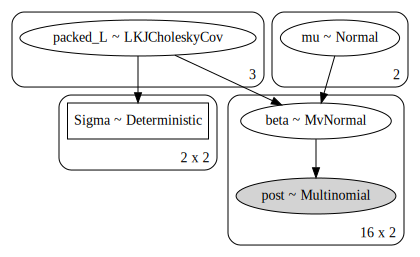

In [556]:
pm.model_to_graphviz(model_hier)

In [557]:
with model_hier:
    prior_sample = pm.sample_prior_predictive(samples=1000)

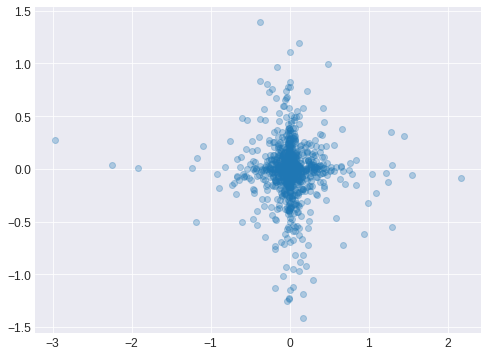

In [558]:
plt.figure(figsize=(8, 6))
plt.plot(
    prior_sample['beta'][:, 0], 
    prior_sample['beta'][:, 1], 'o', alpha=0.3);

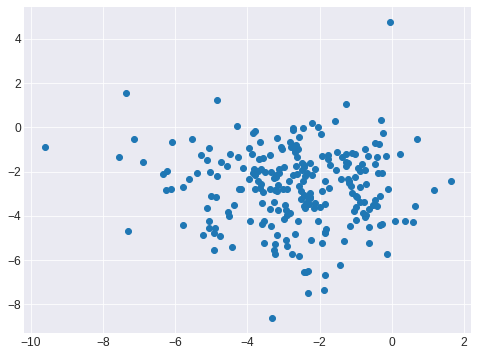

In [559]:
plt.figure(figsize=(8, 6))
plt.plot(
    logit(prior_sample['beta'][:, 0]),
    logit(prior_sample['beta'][:, 1]), 'o');

In [502]:
i = 0
plt.plot(prior_sample['alphas'][:, 0, 0], prior_sample['alphas'][:, 0, 1], 'o')

KeyError: 'alphas'

In [503]:
with model_hier:
    trace_2 = pm.sample(draws=1_000, tune=5_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, mu, packed_L]
Sampling 4 chains, 114 divergences: 100%|██████████| 24000/24000 [03:46<00:00, 105.93draws/s]
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [504]:
arviz.summary(trace_2, var_names=['beta', 'mu'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"beta[0,0]",-0.515,0.264,-1.078,-0.098,0.011,0.008,592.0,592.0,595.0,1330.0,1.01
"beta[0,1]",0.390,0.312,-0.109,0.930,0.017,0.012,345.0,345.0,385.0,487.0,1.02
"beta[1,0]",-0.433,0.214,-0.871,-0.019,0.007,0.005,1011.0,940.0,915.0,1237.0,1.01
"beta[1,1]",0.339,0.258,-0.104,0.855,0.012,0.009,437.0,437.0,461.0,604.0,1.02
"beta[2,0]",-0.446,0.183,-0.848,-0.143,0.009,0.006,427.0,427.0,444.0,486.0,1.02
"beta[2,1]",0.355,0.255,-0.067,0.831,0.013,0.009,396.0,396.0,423.0,603.0,1.01
"beta[3,0]",-0.488,0.221,-0.955,-0.116,0.009,0.006,585.0,585.0,531.0,1175.0,1.01
"beta[3,1]",0.382,0.311,-0.074,0.969,0.016,0.011,372.0,372.0,403.0,536.0,1.02
"beta[4,0]",-0.440,0.220,-0.903,-0.061,0.008,0.007,674.0,539.0,730.0,561.0,1.01
"beta[4,1]",0.340,0.272,-0.065,0.863,0.011,0.008,603.0,603.0,661.0,813.0,1.02


In [571]:
prueba = arviz.from_pymc3(trace_2)

In [576]:
%%prun?
# arviz.plot_trace(prueba, combined=True);

Docstring:
Run a statement through the python code profiler.

Usage, in line mode:
  %prun [options] statement

Usage, in cell mode:
  %%prun [options] [statement]
  code...
  code...

In cell mode, the additional code lines are appended to the (possibly
empty) statement in the first line.  Cell mode allows you to easily
profile multiline blocks without having to put them in a separate
function.

The given statement (which doesn't require quote marks) is run via the
python profiler in a manner similar to the profile.run() function.
Namespaces are internally managed to work correctly; profile.run
cannot be used in IPython because it makes certain assumptions about
namespaces which do not hold under IPython.

Options:

-l <limit>
  you can place restrictions on what or how much of the
  profile gets printed. The limit value can be:

     * A string: only information for function names containing this string
       is printed.

     * An integer: only these many lines are printed.

     *

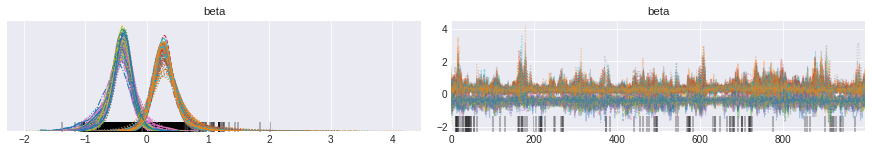

In [573]:
# pm.traceplot(trace_2, var_names=['beta']);
# arviz.plot_trace(trace_2, var_names=['beta'], coords={'2':2});

If you want to check the covariance matrix

In [506]:
matrix_s = trace_2['Sigma'].mean(axis=0)

In [507]:
matrix_s

array([[0.05553475, 0.00057874],
       [0.00057874, 0.07489045]])

From that, you get $\tau_1$ and $\tau_2$

In [508]:
tau1, tau2 = np.sqrt(matrix_s[0, 0]), np.sqrt(matrix_s[1, 1])
print(tau1, tau2)

0.23565812063092312 0.2736611968654907


And then $\rho$

In [509]:
rho = matrix_s[1, 0] / (tau1 * tau2)

In [510]:
rho

0.008974016733377305

Now, the goal is to reproduce the figure 8.1 (b).

In [511]:
with model_hier:
    ppc_hier = pm.sample_posterior_predictive(trace_2, samples=1_000, var_names=['beta'])

/home/rosgori/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:00<00:00, 14674.07it/s]


In [512]:
ppc_hier['beta'].shape

(1000, 16, 2)

In [513]:
values[:, 0] / (values[:, 0] + values[:, 1])

array([0.3255814 , 0.51111111, 0.53061224, 0.47058824, 0.45238095,
       0.5       , 0.56730769, 0.62015504, 0.66666667, 0.53571429,
       0.56043956, 0.61212121, 0.51515152, 0.60294118, 0.59292035,
       0.60526316])

In [524]:
ppc_hier['beta'] = logistic(ppc_hier['beta'])
# ppc_hier['beta'] = ppc_hier['beta']

Remember that from 

\begin{align}
    \alpha_{1j} &= \dfrac{\theta_{1j}}{\theta_{1j} + \theta_{2j}} \\
    \alpha_{2j} &= 1 - \theta_{3j}
\end{align}

you can get $\theta_{1j}$ and $\theta_{2j}$

In [525]:
th1 = []

for i in range(16):
    result1 =  2 * ppc_hier['beta'][:, i, 0] * ppc_hier['beta'][:, i, 1] - ppc_hier['beta'][:, i, 1] 
#     result1 = - 2 * ppc_hier['alphas'][:, i, 0] * ppc_hier['alphas'][:, i, 1] + ppc_hier['alphas'][:, i, 1] 
    th1.append(list(result1))

In [526]:
th1 = np.asarray(th1)
th1.shape

(16, 1000)

In [528]:
result2 = np.sum(th1.T * proportion / np.sum(proportion), axis=1)
result2[:15]

array([0.13474574, 0.13206396, 0.12006383, 0.14417826, 0.13744859,
       0.12955934, 0.13110731, 0.13301547, 0.13427609, 0.13036162,
       0.12951439, 0.12993904, 0.12792267, 0.12701882, 0.12755265])

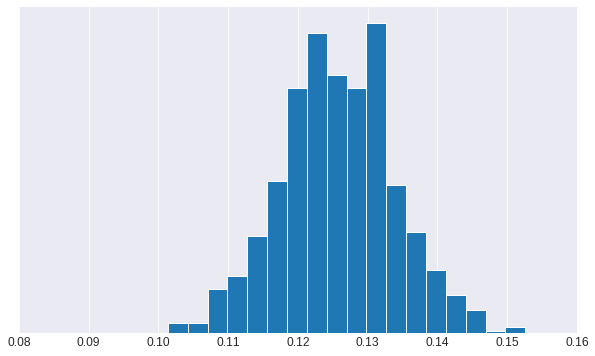

In [533]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(result2 , bins=18, edgecolor='w', density=True)
plt.xlim(0.08, .16)
plt.yticks([]);

As you can see, the figure is quite similar, except that there is a minus sing. The next step would be the model checking, but it would be pointless (you could do it) and the results would not be right.

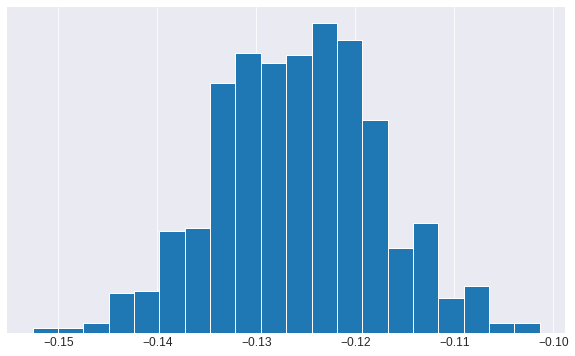

In [534]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(-result2 , bins=20, edgecolor='w', density=True) # With a minus
plt.yticks([]);

Why? I don't know, nevertheless, it is really weird.

In [93]:
%load_ext watermark

In [94]:
%watermark -iv -v -p theano,scipy,matplotlib -m

numpy   1.18.1
pandas  1.0.1
pymc3   3.8
seaborn 0.10.0
arviz   0.7.0
CPython 3.7.6
IPython 7.12.0

theano 1.0.4
scipy 1.4.1
matplotlib 3.1.3

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-91-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


## **With pystan**

This section is to reproduce the figure 8.1 (a) and the figure 8.1 (b) with Stan.

In [19]:
import pystan
print(pystan.__version__)

2.19.1.1


In [20]:
modelo="""
data {
  int<lower=0> N;
  int<lower=0> n;
  int y_obs[N, n];
  vector[n] alpha;
}

parameters {
  
  simplex[n] theta[N];
}

model {
  
  for (i in 1:N)
    theta[i] ~ dirichlet(alpha);
  
  for (i in 1:N)
    y_obs[i] ~ multinomial(theta[i]);
}

"""

In [21]:
stan_modelo = pystan.StanModel(model_code=modelo)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2a28c5090c429737936718a5aee45413 NOW.


In [22]:
data2 = {'N': 16,
       'n': 3,
       'alpha': [1,1,1],
       'y_obs': values.astype(int)}

In [23]:
fit = stan_modelo.sampling(data=data2)

In [24]:
print(fit.stansummary(digits_summary=3))

Inference for Stan model: anon_model_2a28c5090c429737936718a5aee45413.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
theta[1,1]    0.301 7.22e-4  0.065   0.182   0.255     0.3   0.344   0.436   7991    1.0
theta[2,1]    0.488 7.87e-4   0.07   0.351   0.441   0.489   0.536   0.625   7995    1.0
theta[3,1]    0.465  4.0e-4  0.038   0.391   0.438   0.464    0.49   0.541   9070  0.999
theta[4,1]    0.459 7.02e-4   0.06   0.343   0.417   0.458     0.5   0.578   7298  0.999
theta[5,1]      0.4 7.67e-4  0.066   0.276   0.355   0.399   0.443   0.536   7367    1.0
theta[6,1]    0.443 6.13e-4   0.05   0.347   0.408   0.443   0.476   0.543   6765    1.0
theta[7,1]    0.504 5.46e-4  0.046   0.415   0.473   0.504   0.536   0.595   6994  0.999
theta[8,1]    0.548 4.61e-4  0.041   0.467    0.52   0.547   0.575   0.629   7930    1.0
theta[9,1]

In [25]:
samples = fit.extract(permuted=True)['theta']

In [26]:
samples.shape

(4000, 16, 3)

In [27]:
samples[0, :, 0]

array([0.28969053, 0.55576013, 0.46880875, 0.62499109, 0.31250517,
       0.45638551, 0.51475111, 0.54379053, 0.50190306, 0.53247051,
       0.49688836, 0.55487369, 0.47213411, 0.56546164, 0.5566992 ,
       0.5919083 ])

In [28]:
np.mean(samples[:, 0, 2])

0.10000779136186363

In [29]:
diff3 = []

for i in range(16):
    result3 = samples[:, i, 0] - samples[:, i, 1]
    diff3.append(list(result3))

In [30]:
diff3 = np.asarray(diff3)
diff3

array([[-0.35447872, -0.17297568, -0.17596767, ..., -0.2805937 ,
        -0.47618688, -0.13276545],
       [ 0.15755553, -0.0566407 ,  0.03664864, ...,  0.11863572,
        -0.0685502 ,  0.06912136],
       [ 0.04329983,  0.14636458,  0.10092675, ...,  0.24371403,
        -0.00409195, -0.03231013],
       ...,
       [ 0.22064079,  0.24680335,  0.09860484, ...,  0.09248436,
         0.13465215,  0.08122155],
       [ 0.22483055,  0.15969287,  0.10511641, ...,  0.21970223,
         0.14075503,  0.0461641 ],
       [ 0.27342662,  0.16853591,  0.18921759, ...,  0.28294102,
         0.16541389,  0.16547692]])

In [31]:
diff3[:, 3999]

array([-0.13276545,  0.06912136, -0.03231013,  0.16520493, -0.16403938,
        0.06041195,  0.02550831,  0.19337253, -0.0194513 ,  0.03460096,
        0.16171201,  0.16481575, -0.24930883,  0.08122155,  0.0461641 ,
        0.16547692])

In [32]:
res2 = np.sum(diff3.T * proportion / np.sum(proportion), axis=1)

In [33]:
res2.shape

(4000,)

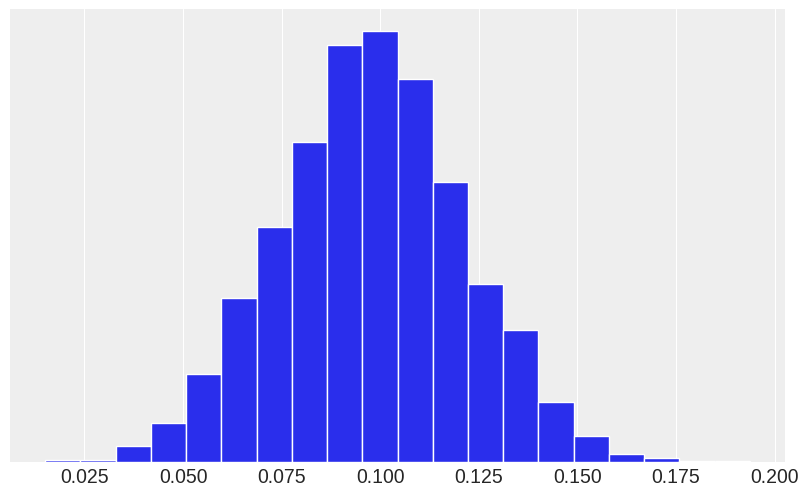

In [34]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(res2, bins=20, edgecolor='w', density=True)
plt.yticks([]);
# plt.savefig('model_non_hier.png', dpi=120)

With this, the figure 8.1 (a) is very similiar to this one.

### **Pystan with the hierarchical model**

In [35]:
modelo2 = """
data {
  int<lower=0> N;
  int<lower=0> n;
  int post[N, n];
}

parameters {
  vector[n] mu;
  cholesky_factor_corr[n] L;
  vector[n] beta[N];
    
}

transformed parameters{
  vector[n] theta[N] ;
  
  for (i in 1:N)
    theta[i] = inv_logit(beta[i]);
     
}

model {

  L ~ lkj_corr_cholesky(3.0);
 
  mu ~ exponential(0.01);
  
  beta ~ multi_normal_cholesky(mu, L);
  
    
  for (i in 1:N)
    post[i] ~ multinomial(theta[i]);
  
}

generated quantities {

  corr_matrix[n] Sigma;
  Sigma = multiply_lower_tri_self_transpose(L);
  
}


"""

modelo3 = """
    data {
      int<lower=0> N;
      int<lower=0> n;
      int post[N, n];
    }

    parameters {
      vector[n] mu;
      cholesky_factor_corr[n] L;
      vector[n] beta[N];
      simplex[n] thetas[N];

    }

    transformed parameters{

      vector<lower=0, upper=1>[n] alphas[N];


      for (i in 1:N)
        alphas[i] = inv_logit(beta[i]);

    }

    model {

      L ~ lkj_corr_cholesky(3.0);

      mu ~ normal(0, 5);

      beta ~ multi_normal_cholesky(mu, L);

      for (i in 1:N)
        thetas[i] ~ dirichlet(alphas[i]);

      for (i in 1:N)
        post[i] ~ multinomial(thetas[i]);

    }

    generated quantities {

      corr_matrix[n] Sigma;
      Sigma = multiply_lower_tri_self_transpose(L);

    }

    """

In [36]:
stan_modelo2 = pystan.StanModel(model_code=modelo3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_748691e7ccede7ca1d8cce075e5cc736 NOW.


In [37]:
data3 = {'N': 16,
         'n': 2,
         'post': new_values.astype(int)}

In [38]:
fit2 = stan_modelo2.sampling(data=data3, iter=5000, verbose=True, control={'adapt_delta':0.90}, init=0)

In [39]:
print(fit2.stansummary(digits_summary=3))

Inference for Stan model: anon_model_748691e7ccede7ca1d8cce075e5cc736.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                mean  se_mean       sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
mu[1]          5.003      0.1    2.855   1.046   2.879   4.434   6.604  11.845    818  1.005
mu[2]          5.881    0.078    2.698   1.905   3.854    5.43   7.537  12.034   1185  1.004
L[1,1]           1.0      nan      0.0     1.0     1.0     1.0     1.0     1.0    nan    nan
L[2,1]         -0.01    0.009    0.375  -0.719  -0.284   -0.01   0.262   0.698   1841  1.002
L[1,2]           0.0      nan      0.0     0.0     0.0     0.0     0.0     0.0    nan    nan
L[2,2]         0.921    0.002    0.101   0.627   0.889   0.962   0.992     1.0   2772  1.001
beta[1,1]      5.024    0.101     3.02   0.479   2.839   4.523   6.728  12.022    903  1.004
beta[2,1]       5.02    0.099    2.993   0.574   2.821   4.513   6

In [40]:
samples2 = fit2.extract(permuted=True)['alphas']

In [41]:
th5 = []

for i in range(16):
    res5 =  2 * samples2[:, i, 0] * samples2[:, i, 1] - samples2[:, i, 1] 
#     result1 = - 2 * ppc_hier['alphas'][:, i, 0] * ppc_hier['alphas'][:, i, 1] + ppc_hier['alphas'][:, i, 1] 
    th5.append(list(res5))

In [42]:
th5 = np.asarray(th5)
th5.shape

(16, 10000)

In [43]:
result5 = np.sum(th5.T * proportion / np.sum(proportion), axis=1)
print(result5.shape)
result5[:15]

(10000,)


array([0.93894789, 0.96938789, 0.81823725, 0.96043972, 0.98275602,
       0.49781907, 0.93636218, 0.80706103, 0.99502264, 0.77100402,
       0.79591668, 0.83848738, 0.40896394, 0.9346735 , 0.77259644])

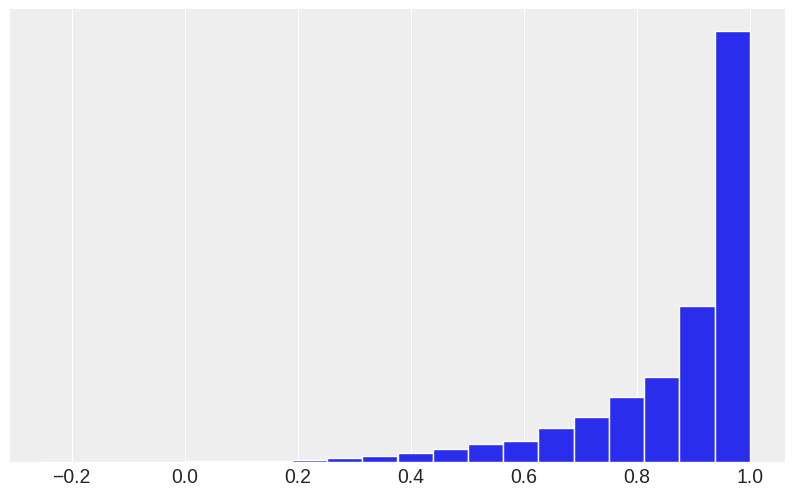

In [44]:
plt.figure(figsize=(10, 6))
_, _, _ = plt.hist(result5 , bins=20, edgecolor='w', density=True)
plt.yticks([]);
# plt.savefig('model_hier.png', dpi=120)

Again, very similar to the figure 8.1 (b), except for a minus sign. Why? It is not clear at the moment.